In [64]:
import pandas as pd
import numpy as np
from statsmodels.tsa.deterministic import DeterministicProcess
import matplotlib.pyplot as plt
import seaborn as sns

# Data analysis
### Detrend the data
#### Seasonality (Monthly / Semi-monthly circle (Wage related))

### Adding features
#### Add daily oil price into training features (fillna [2013-1-1] with the bfill method); daily oil price has negative correlation with most of products 
#### Add earthquake effect into training features.
#### Holiday-related features (holiday_events: 0/1)
### Prediction
#### Create models for each store or each cluster of stores? (54 stores, 17 clusters)
#### Use the hybrid model. LinearRegressor or LogisticRegressor for trend prediction, RF or GBR for residual prediction.


In [309]:
holiday_events=pd.read_csv('holidays_events.csv',parse_dates=['date'])
oil=pd.read_csv('oil.csv',parse_dates=['date'])
stores=pd.read_csv('stores.csv')
train=pd.read_csv('train.csv',parse_dates=['date'])
test=pd.read_csv('test.csv')
transactions=pd.read_csv('transactions.csv')

## Correlation between oil price and sales of various products

Text(0, 0.5, 'Correlation with daily oil price')

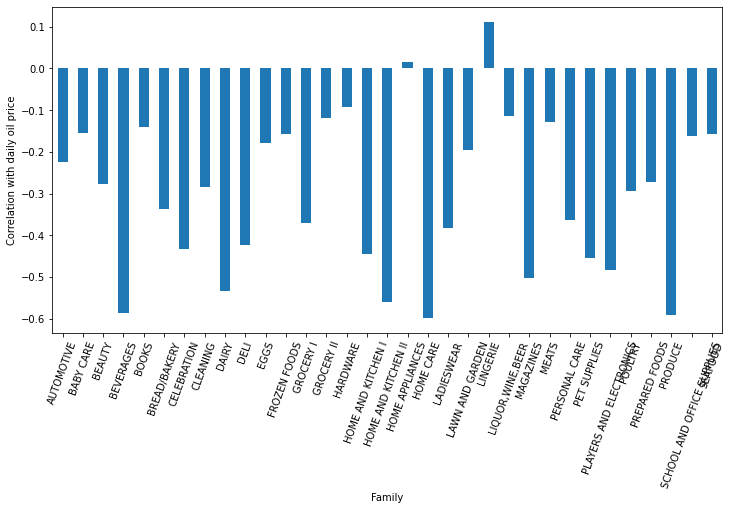

In [418]:
oil_corr=pd.DataFrame(columns=sorted(train['store_nbr'].unique()),index = train['family'].unique())

for i in train['store_nbr'].unique():
    df=train[train['store_nbr']==i].pivot('date','family','sales').merge(oil.set_index('date'),
                                                                         on='date')
    oil_corr[i]=df.corr()['dcoilwtico'][:-1]

f,ax=plt.subplots(figsize=(12,6))
oil_corr.mean(axis=1).plot(kind='bar',ax=ax,rot=70) # Average over all the stores
ax.set_xlabel('Family')
ax.set_ylabel('Correlation with daily oil price')

<AxesSubplot:xlabel='date'>

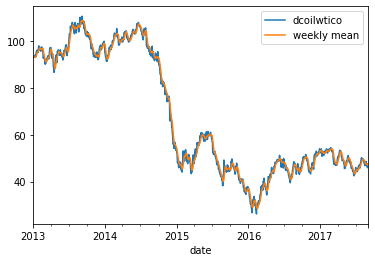

In [413]:
# Not only the daily price, but also the price over the past week should be considered
oil.fillna(method='bfill',inplace=True) # fill nan value with backfill method 
oil['weekly mean']=oil['dcoilwtico'].rolling(7,min_periods=1).mean() # compute the 7-day averaged oil price
oil.plot(x='date',y=['dcoilwtico','weekly mean'])

## Holiday-related features (holiday_events: 0/1)

In [414]:
## Merge the oil information to training dataset
train=train.merge(oil,on='date',how='left')

In [343]:
print(holiday_events['locale'].value_counts())
## We count 'Holiday' with transferred == 'False','Event','Additional','Transfer','Bridge','Work Day'
## as true holidays
holiday_events_new=holiday_events[holiday_events['transferred']==False]
## Find national holidays 
National_holiday = holiday_events_new[holiday_events_new['locale']=='National']['date']
train['holiday_events']=train['date'].apply(lambda d:1 if d in list(National_holiday) else 0)

In [344]:
train['holiday_events'].value_counts()

0    2758536
1     242352
Name: holiday_events, dtype: int64

In [379]:
## Find local holidays for each store
Local_holiday = holiday_events_new[(holiday_events_new['locale']=='Regional')|(holiday_events_new['locale']=='Local')][['date','locale_name']]
stores['locale_name']=stores['city']
store_holiday = stores.merge(Local_holiday,on='locale_name',how='left')
for i in range(len(stores)):
    date = store_holiday[store_holiday['store_nbr']==i+1]['date']
    train.loc[(train['store_nbr']==i+1)&(train['holiday_events']==0),'holiday_events'] = train.loc[(train['store_nbr']==i+1)&(train['holiday_events']==0)]['date'].apply(lambda d:1 if d in list(date) else 0)

In [400]:
train['holiday_events'].value_counts()

0    2747118
1     253770
Name: holiday_events, dtype: int64

## Group the stores in terms of clusters

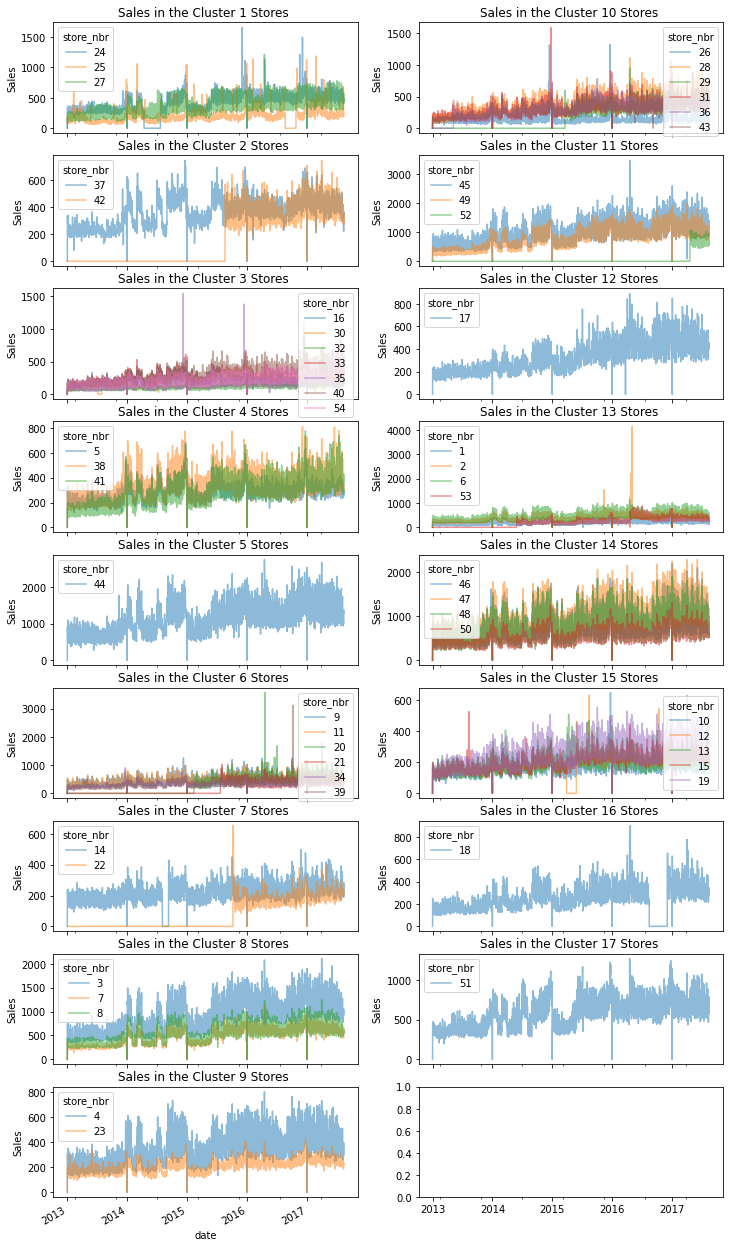

In [508]:
# Stores in the same cluster have similar sales pattern
n_clusters = len(stores['cluster'].unique())
f,ax=plt.subplots(nrows=9,ncols=2,figsize=(12,24),sharex=True)
for i in range(n_clusters):
    j=0
    if i>=9:
        k=1
        j+=i-9
    else:
        k=0
        j+=i
    pd.pivot_table(train.loc[train['store_nbr'].isin(list(stores.iloc[list(stores.groupby('cluster').groups[i+1])]['store_nbr']))],
                   values = 'sales',
                   index='date',
                   columns='store_nbr').plot(ax=ax[j][k],alpha=0.5)
    ax[j][k].set_title('Sales in the Cluster {} Stores '.format(i+1))
    ax[j][k].set_ylabel('Sales')

## Questions:
### Meaning of ‘transaction’?? How to use this feature?

<AxesSubplot:xlabel='date'>

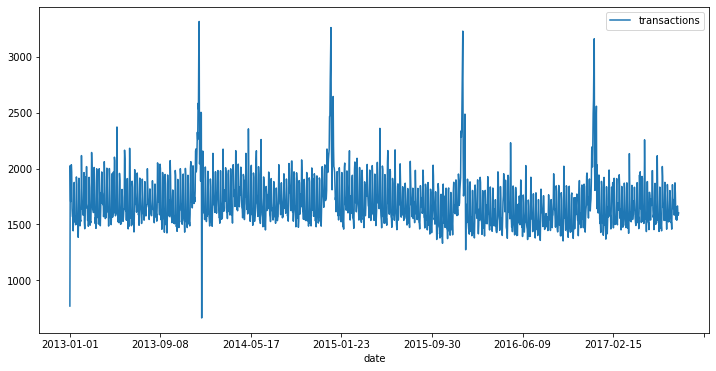

In [432]:
# Transactions have annual cycle.
f,ax=plt.subplots(figsize=(12,6))
transactions.groupby('date').mean().plot(y='transactions',ax=ax)